<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[03:09:02] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


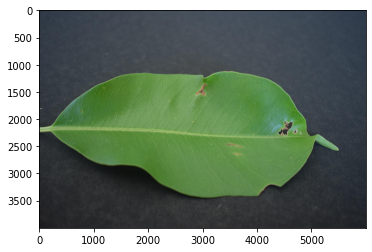

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

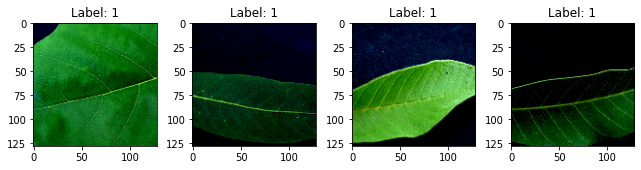

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[03:09:08] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[03:09:10] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2512553598302902 samples/sec                   batch loss = 0.9496035575866699 | accuracy = 0.55


Epoch[1] Batch[10] Speed: 1.2573341800888254 samples/sec                   batch loss = 0.2612156569957733 | accuracy = 0.65


Epoch[1] Batch[15] Speed: 1.2724784439147385 samples/sec                   batch loss = 0.33594971895217896 | accuracy = 0.7


Epoch[1] Batch[20] Speed: 1.2664940285239439 samples/sec                   batch loss = 0.4618743360042572 | accuracy = 0.6625


Epoch[1] Batch[25] Speed: 1.263133041574965 samples/sec                   batch loss = 0.7002846002578735 | accuracy = 0.59


Epoch[1] Batch[30] Speed: 1.270909648857874 samples/sec                   batch loss = 0.6913908123970032 | accuracy = 0.5916666666666667


Epoch[1] Batch[35] Speed: 1.2226869235911042 samples/sec                   batch loss = 0.5137172341346741 | accuracy = 0.6214285714285714


Epoch[1] Batch[40] Speed: 1.2661181206511947 samples/sec                   batch loss = 0.6263325214385986 | accuracy = 0.61875


Epoch[1] Batch[45] Speed: 1.2650291246264982 samples/sec                   batch loss = 0.7615092992782593 | accuracy = 0.6166666666666667


Epoch[1] Batch[50] Speed: 1.273938992646679 samples/sec                   batch loss = 0.6131135821342468 | accuracy = 0.61


Epoch[1] Batch[55] Speed: 1.2711377631324334 samples/sec                   batch loss = 0.6641883850097656 | accuracy = 0.6090909090909091


Epoch[1] Batch[60] Speed: 1.267955812796296 samples/sec                   batch loss = 0.49426424503326416 | accuracy = 0.6125


Epoch[1] Batch[65] Speed: 1.2678956362340366 samples/sec                   batch loss = 0.6347688436508179 | accuracy = 0.6


Epoch[1] Batch[70] Speed: 1.2651510387045117 samples/sec                   batch loss = 0.617169976234436 | accuracy = 0.6035714285714285


Epoch[1] Batch[75] Speed: 1.2678677538081453 samples/sec                   batch loss = 0.5991210341453552 | accuracy = 0.6066666666666667


Epoch[1] Batch[80] Speed: 1.2650517313311134 samples/sec                   batch loss = 0.6790016889572144 | accuracy = 0.6


Epoch[1] Batch[85] Speed: 1.2683422095481194 samples/sec                   batch loss = 0.8612489700317383 | accuracy = 0.5882352941176471


Epoch[1] Batch[90] Speed: 1.270588655834931 samples/sec                   batch loss = 0.41834309697151184 | accuracy = 0.5944444444444444


Epoch[1] Batch[95] Speed: 1.2672180861272715 samples/sec                   batch loss = 0.336052268743515 | accuracy = 0.5973684210526315


Epoch[1] Batch[100] Speed: 1.269556034168983 samples/sec                   batch loss = 0.40592727065086365 | accuracy = 0.605


Epoch[1] Batch[105] Speed: 1.2739903602611855 samples/sec                   batch loss = 1.844883918762207 | accuracy = 0.5976190476190476


Epoch[1] Batch[110] Speed: 1.268930740130233 samples/sec                   batch loss = 0.7393785715103149 | accuracy = 0.6


Epoch[1] Batch[115] Speed: 1.2656737802345748 samples/sec                   batch loss = 0.676443338394165 | accuracy = 0.6043478260869565


Epoch[1] Batch[120] Speed: 1.2704821431668107 samples/sec                   batch loss = 0.6952468752861023 | accuracy = 0.6083333333333333


Epoch[1] Batch[125] Speed: 1.268411826251364 samples/sec                   batch loss = 0.7610456347465515 | accuracy = 0.604


Epoch[1] Batch[130] Speed: 1.2662305924376434 samples/sec                   batch loss = 0.2984018325805664 | accuracy = 0.6134615384615385


Epoch[1] Batch[135] Speed: 1.2679913656469837 samples/sec                   batch loss = 1.0296026468276978 | accuracy = 0.6148148148148148


Epoch[1] Batch[140] Speed: 1.2622349901148644 samples/sec                   batch loss = 0.7186148762702942 | accuracy = 0.6142857142857143


Epoch[1] Batch[145] Speed: 1.2674521540516623 samples/sec                   batch loss = 0.5084241032600403 | accuracy = 0.6189655172413793


Epoch[1] Batch[150] Speed: 1.2684933431230694 samples/sec                   batch loss = 0.31312882900238037 | accuracy = 0.6233333333333333


Epoch[1] Batch[155] Speed: 1.2565270674105322 samples/sec                   batch loss = 0.515889585018158 | accuracy = 0.6225806451612903


Epoch[1] Batch[160] Speed: 1.264010658628696 samples/sec                   batch loss = 0.23666617274284363 | accuracy = 0.6296875


Epoch[1] Batch[165] Speed: 1.266055825423133 samples/sec                   batch loss = 0.4309661388397217 | accuracy = 0.6318181818181818


Epoch[1] Batch[170] Speed: 1.2675340264323944 samples/sec                   batch loss = 0.5436530709266663 | accuracy = 0.6323529411764706


Epoch[1] Batch[175] Speed: 1.270781520952211 samples/sec                   batch loss = 0.5888234376907349 | accuracy = 0.6342857142857142


Epoch[1] Batch[180] Speed: 1.270689026930732 samples/sec                   batch loss = 0.7145824432373047 | accuracy = 0.6291666666666667


Epoch[1] Batch[185] Speed: 1.2642728859119372 samples/sec                   batch loss = 0.46656331419944763 | accuracy = 0.6364864864864865


Epoch[1] Batch[190] Speed: 1.2606072190981075 samples/sec                   batch loss = 0.7508941888809204 | accuracy = 0.6355263157894737


Epoch[1] Batch[195] Speed: 1.26677278215496 samples/sec                   batch loss = 1.154276967048645 | accuracy = 0.6384615384615384


Epoch[1] Batch[200] Speed: 1.2634562724144438 samples/sec                   batch loss = 0.35257285833358765 | accuracy = 0.64125


Epoch[1] Batch[205] Speed: 1.268162257975517 samples/sec                   batch loss = 0.7011908292770386 | accuracy = 0.6451219512195122


Epoch[1] Batch[210] Speed: 1.266676949743463 samples/sec                   batch loss = 0.5680748820304871 | accuracy = 0.6464285714285715


Epoch[1] Batch[215] Speed: 1.2648532587061676 samples/sec                   batch loss = 0.27738845348358154 | accuracy = 0.6465116279069767


Epoch[1] Batch[220] Speed: 1.2673604312459963 samples/sec                   batch loss = 1.2751837968826294 | accuracy = 0.6454545454545455


Epoch[1] Batch[225] Speed: 1.2656084735911264 samples/sec                   batch loss = 1.3848686218261719 | accuracy = 0.6455555555555555


Epoch[1] Batch[230] Speed: 1.261274682197003 samples/sec                   batch loss = 0.3051086962223053 | accuracy = 0.6489130434782608


Epoch[1] Batch[235] Speed: 1.2681437575922676 samples/sec                   batch loss = 0.5704934000968933 | accuracy = 0.65


Epoch[1] Batch[240] Speed: 1.268589642432004 samples/sec                   batch loss = 0.36483174562454224 | accuracy = 0.6520833333333333


Epoch[1] Batch[245] Speed: 1.2731481063408363 samples/sec                   batch loss = 0.292581170797348 | accuracy = 0.6540816326530612


Epoch[1] Batch[250] Speed: 1.272881219109679 samples/sec                   batch loss = 0.6097459197044373 | accuracy = 0.656


Epoch[1] Batch[255] Speed: 1.2686088273077143 samples/sec                   batch loss = 0.5855088829994202 | accuracy = 0.6549019607843137


Epoch[1] Batch[260] Speed: 1.2627749032797027 samples/sec                   batch loss = 0.48052942752838135 | accuracy = 0.6538461538461539


Epoch[1] Batch[265] Speed: 1.2701487690950444 samples/sec                   batch loss = 0.6003838181495667 | accuracy = 0.6547169811320754


Epoch[1] Batch[270] Speed: 1.2650017496565342 samples/sec                   batch loss = 1.0575881004333496 | accuracy = 0.6537037037037037


Epoch[1] Batch[275] Speed: 1.2670130007438707 samples/sec                   batch loss = 0.6222977638244629 | accuracy = 0.6518181818181819


Epoch[1] Batch[280] Speed: 1.266855906038363 samples/sec                   batch loss = 0.6529510617256165 | accuracy = 0.6508928571428572


Epoch[1] Batch[285] Speed: 1.2645161601532022 samples/sec                   batch loss = 0.3881871700286865 | accuracy = 0.6517543859649123


Epoch[1] Batch[290] Speed: 1.2678705324141284 samples/sec                   batch loss = 0.5260398387908936 | accuracy = 0.65


Epoch[1] Batch[295] Speed: 1.2638682080482442 samples/sec                   batch loss = 0.4422991871833801 | accuracy = 0.6457627118644068


Epoch[1] Batch[300] Speed: 1.2663700393251256 samples/sec                   batch loss = 0.6926410794258118 | accuracy = 0.6475


Epoch[1] Batch[305] Speed: 1.265863818890773 samples/sec                   batch loss = 0.38884174823760986 | accuracy = 0.6475409836065574


Epoch[1] Batch[310] Speed: 1.2703768988679578 samples/sec                   batch loss = 0.40097567439079285 | accuracy = 0.6524193548387097


Epoch[1] Batch[315] Speed: 1.2656896305240244 samples/sec                   batch loss = 0.7202733755111694 | accuracy = 0.6547619047619048


Epoch[1] Batch[320] Speed: 1.2650309369485542 samples/sec                   batch loss = 0.5235735774040222 | accuracy = 0.65625


Epoch[1] Batch[325] Speed: 1.2722693369444074 samples/sec                   batch loss = 0.6503047943115234 | accuracy = 0.6569230769230769


Epoch[1] Batch[330] Speed: 1.2623758379394245 samples/sec                   batch loss = 0.42892199754714966 | accuracy = 0.6590909090909091


Epoch[1] Batch[335] Speed: 1.2689274770050036 samples/sec                   batch loss = 0.7754738330841064 | accuracy = 0.6611940298507463


Epoch[1] Batch[340] Speed: 1.2646283474964306 samples/sec                   batch loss = 0.44978034496307373 | accuracy = 0.6625


Epoch[1] Batch[345] Speed: 1.2676081516044968 samples/sec                   batch loss = 0.6415641903877258 | accuracy = 0.6630434782608695


Epoch[1] Batch[350] Speed: 1.2675986699943 samples/sec                   batch loss = 0.3752036988735199 | accuracy = 0.6635714285714286


Epoch[1] Batch[355] Speed: 1.262967685170457 samples/sec                   batch loss = 0.26831623911857605 | accuracy = 0.6661971830985915


Epoch[1] Batch[360] Speed: 1.264736264384899 samples/sec                   batch loss = 0.30182573199272156 | accuracy = 0.6673611111111111


Epoch[1] Batch[365] Speed: 1.258486611508602 samples/sec                   batch loss = 0.59308260679245 | accuracy = 0.6678082191780822


Epoch[1] Batch[370] Speed: 1.2641347577277031 samples/sec                   batch loss = 0.661911129951477 | accuracy = 0.6675675675675675


Epoch[1] Batch[375] Speed: 1.2660537235438212 samples/sec                   batch loss = 0.16674737632274628 | accuracy = 0.6706666666666666


Epoch[1] Batch[380] Speed: 1.265857037635391 samples/sec                   batch loss = 0.4647952914237976 | accuracy = 0.6703947368421053


Epoch[1] Batch[385] Speed: 1.2664944109491587 samples/sec                   batch loss = 0.5312447547912598 | accuracy = 0.6681818181818182


Epoch[1] Batch[390] Speed: 1.2727714250448787 samples/sec                   batch loss = 0.4974729120731354 | accuracy = 0.6679487179487179


Epoch[1] Batch[395] Speed: 1.261600567528713 samples/sec                   batch loss = 0.32670530676841736 | accuracy = 0.669620253164557


Epoch[1] Batch[400] Speed: 1.2648983649870507 samples/sec                   batch loss = 0.7947676777839661 | accuracy = 0.670625


Epoch[1] Batch[405] Speed: 1.2688867853234866 samples/sec                   batch loss = 0.5043684244155884 | accuracy = 0.6697530864197531


Epoch[1] Batch[410] Speed: 1.2698936147585822 samples/sec                   batch loss = 0.4638437032699585 | accuracy = 0.6713414634146342


Epoch[1] Batch[415] Speed: 1.2664265340910206 samples/sec                   batch loss = 0.3701624274253845 | accuracy = 0.6716867469879518


Epoch[1] Batch[420] Speed: 1.263359609248363 samples/sec                   batch loss = 0.9432315230369568 | accuracy = 0.6714285714285714


Epoch[1] Batch[425] Speed: 1.2657636356228998 samples/sec                   batch loss = 0.28361600637435913 | accuracy = 0.6723529411764706


Epoch[1] Batch[430] Speed: 1.2664952714067368 samples/sec                   batch loss = 1.4108010530471802 | accuracy = 0.6732558139534883


Epoch[1] Batch[435] Speed: 1.2694643908359426 samples/sec                   batch loss = 1.4614813327789307 | accuracy = 0.6741379310344827


Epoch[1] Batch[440] Speed: 1.2704767554666259 samples/sec                   batch loss = 0.3060733675956726 | accuracy = 0.6755681818181818


Epoch[1] Batch[445] Speed: 1.2587271916310012 samples/sec                   batch loss = 0.4746381938457489 | accuracy = 0.6741573033707865


Epoch[1] Batch[450] Speed: 1.2649894456134678 samples/sec                   batch loss = 0.6366896033287048 | accuracy = 0.6755555555555556


Epoch[1] Batch[455] Speed: 1.2624878358150327 samples/sec                   batch loss = 0.6228641867637634 | accuracy = 0.6752747252747253


Epoch[1] Batch[460] Speed: 1.2651103980676643 samples/sec                   batch loss = 1.119890570640564 | accuracy = 0.6739130434782609


Epoch[1] Batch[465] Speed: 1.263504038612102 samples/sec                   batch loss = 0.8200376629829407 | accuracy = 0.6736559139784947


Epoch[1] Batch[470] Speed: 1.265438268798346 samples/sec                   batch loss = 0.7815772294998169 | accuracy = 0.675


Epoch[1] Batch[475] Speed: 1.2615647081045898 samples/sec                   batch loss = 0.6315699815750122 | accuracy = 0.6747368421052632


Epoch[1] Batch[480] Speed: 1.265090174122788 samples/sec                   batch loss = 0.7057851552963257 | accuracy = 0.6744791666666666


Epoch[1] Batch[485] Speed: 1.2638033731974536 samples/sec                   batch loss = 0.5345472693443298 | accuracy = 0.6721649484536083


Epoch[1] Batch[490] Speed: 1.2644877590387815 samples/sec                   batch loss = 0.5204918384552002 | accuracy = 0.6714285714285714


Epoch[1] Batch[495] Speed: 1.2639647586119815 samples/sec                   batch loss = 0.5495164394378662 | accuracy = 0.6702020202020202


Epoch[1] Batch[500] Speed: 1.2678071065805725 samples/sec                   batch loss = 1.0396746397018433 | accuracy = 0.671


Epoch[1] Batch[505] Speed: 1.2638175582277404 samples/sec                   batch loss = 0.3027510344982147 | accuracy = 0.6722772277227723


Epoch[1] Batch[510] Speed: 1.2657859820892496 samples/sec                   batch loss = 0.718246579170227 | accuracy = 0.6735294117647059


Epoch[1] Batch[515] Speed: 1.2641897196032106 samples/sec                   batch loss = 0.23309502005577087 | accuracy = 0.675242718446602


Epoch[1] Batch[520] Speed: 1.2650634642431329 samples/sec                   batch loss = 1.0429459810256958 | accuracy = 0.676923076923077


Epoch[1] Batch[525] Speed: 1.2617314053064235 samples/sec                   batch loss = 0.3826083242893219 | accuracy = 0.6766666666666666


Epoch[1] Batch[530] Speed: 1.2597741431325886 samples/sec                   batch loss = 0.455281525850296 | accuracy = 0.6768867924528302


Epoch[1] Batch[535] Speed: 1.2643338624370921 samples/sec                   batch loss = 0.8873865008354187 | accuracy = 0.6771028037383178


Epoch[1] Batch[540] Speed: 1.2642301105789613 samples/sec                   batch loss = 0.8047964572906494 | accuracy = 0.6773148148148148


Epoch[1] Batch[545] Speed: 1.2669677435237803 samples/sec                   batch loss = 2.9871649742126465 | accuracy = 0.6784403669724771


Epoch[1] Batch[550] Speed: 1.268019253510041 samples/sec                   batch loss = 0.3639630973339081 | accuracy = 0.6795454545454546


Epoch[1] Batch[555] Speed: 1.2652115274919227 samples/sec                   batch loss = 0.4269455373287201 | accuracy = 0.6801801801801802


Epoch[1] Batch[560] Speed: 1.2709158104300113 samples/sec                   batch loss = 0.6128870844841003 | accuracy = 0.6808035714285714


Epoch[1] Batch[565] Speed: 1.263478442331955 samples/sec                   batch loss = 0.5100359916687012 | accuracy = 0.6805309734513274


Epoch[1] Batch[570] Speed: 1.2701584812137523 samples/sec                   batch loss = 0.3389076590538025 | accuracy = 0.6815789473684211


Epoch[1] Batch[575] Speed: 1.2620321788862636 samples/sec                   batch loss = 0.9913212060928345 | accuracy = 0.6817391304347826


Epoch[1] Batch[580] Speed: 1.2645262628706495 samples/sec                   batch loss = 0.23646245896816254 | accuracy = 0.6823275862068966


Epoch[1] Batch[585] Speed: 1.2610656389856914 samples/sec                   batch loss = 0.41615617275238037 | accuracy = 0.6833333333333333


Epoch[1] Batch[590] Speed: 1.2621766847061995 samples/sec                   batch loss = 0.5129109621047974 | accuracy = 0.6851694915254237


Epoch[1] Batch[595] Speed: 1.2662678644720622 samples/sec                   batch loss = 0.2254275232553482 | accuracy = 0.6857142857142857


Epoch[1] Batch[600] Speed: 1.2605073925849581 samples/sec                   batch loss = 0.604436457157135 | accuracy = 0.6845833333333333


Epoch[1] Batch[605] Speed: 1.262521657570186 samples/sec                   batch loss = 0.6718342304229736 | accuracy = 0.6847107438016529


Epoch[1] Batch[610] Speed: 1.2727595487220071 samples/sec                   batch loss = 0.692879319190979 | accuracy = 0.6827868852459016


Epoch[1] Batch[615] Speed: 1.2699480211373189 samples/sec                   batch loss = 0.37931832671165466 | accuracy = 0.6841463414634147


Epoch[1] Batch[620] Speed: 1.263968472389798 samples/sec                   batch loss = 0.6294673681259155 | accuracy = 0.6846774193548387


Epoch[1] Batch[625] Speed: 1.2704378884120548 samples/sec                   batch loss = 0.44221603870391846 | accuracy = 0.6848


Epoch[1] Batch[630] Speed: 1.2626217083698241 samples/sec                   batch loss = 0.1664610207080841 | accuracy = 0.6853174603174603


Epoch[1] Batch[635] Speed: 1.265029506167552 samples/sec                   batch loss = 0.4331894814968109 | accuracy = 0.6858267716535433


Epoch[1] Batch[640] Speed: 1.2604160093084922 samples/sec                   batch loss = 0.24255269765853882 | accuracy = 0.6875


Epoch[1] Batch[645] Speed: 1.263210362212268 samples/sec                   batch loss = 0.2951848804950714 | accuracy = 0.6891472868217055


Epoch[1] Batch[650] Speed: 1.264225061565845 samples/sec                   batch loss = 0.5543880462646484 | accuracy = 0.69


Epoch[1] Batch[655] Speed: 1.2611170164266325 samples/sec                   batch loss = 0.09328658133745193 | accuracy = 0.6900763358778625


Epoch[1] Batch[660] Speed: 1.2644537365645512 samples/sec                   batch loss = 0.5516653060913086 | accuracy = 0.6897727272727273


Epoch[1] Batch[665] Speed: 1.264629396070164 samples/sec                   batch loss = 0.4974134564399719 | accuracy = 0.6902255639097744


Epoch[1] Batch[670] Speed: 1.2733327615793464 samples/sec                   batch loss = 0.2527785301208496 | accuracy = 0.6902985074626866


Epoch[1] Batch[675] Speed: 1.2657960096062548 samples/sec                   batch loss = 0.655884861946106 | accuracy = 0.6892592592592592


Epoch[1] Batch[680] Speed: 1.2627573200896933 samples/sec                   batch loss = 0.3226127028465271 | accuracy = 0.6900735294117647


Epoch[1] Batch[685] Speed: 1.2631686097945694 samples/sec                   batch loss = 0.7703236937522888 | accuracy = 0.6905109489051094


Epoch[1] Batch[690] Speed: 1.2694317328878235 samples/sec                   batch loss = 0.5225139260292053 | accuracy = 0.6909420289855073


Epoch[1] Batch[695] Speed: 1.2637651989592922 samples/sec                   batch loss = 0.27184292674064636 | accuracy = 0.6913669064748201


Epoch[1] Batch[700] Speed: 1.2542666346494005 samples/sec                   batch loss = 0.40619224309921265 | accuracy = 0.6914285714285714


Epoch[1] Batch[705] Speed: 1.2658833034654515 samples/sec                   batch loss = 0.13705310225486755 | accuracy = 0.6929078014184397


Epoch[1] Batch[710] Speed: 1.2642560231299282 samples/sec                   batch loss = 0.4609662592411041 | accuracy = 0.6929577464788732


Epoch[1] Batch[715] Speed: 1.267819657110471 samples/sec                   batch loss = 0.4040778875350952 | accuracy = 0.693006993006993


Epoch[1] Batch[720] Speed: 1.269765787726381 samples/sec                   batch loss = 0.6151637434959412 | accuracy = 0.6930555555555555


Epoch[1] Batch[725] Speed: 1.2666575363605381 samples/sec                   batch loss = 0.6203467845916748 | accuracy = 0.6937931034482758


Epoch[1] Batch[730] Speed: 1.2623703288027184 samples/sec                   batch loss = 0.37187403440475464 | accuracy = 0.6948630136986301


Epoch[1] Batch[735] Speed: 1.269399172665346 samples/sec                   batch loss = 0.7067362666130066 | accuracy = 0.6948979591836735


Epoch[1] Batch[740] Speed: 1.2671612335980942 samples/sec                   batch loss = 1.3808178901672363 | accuracy = 0.6952702702702702


Epoch[1] Batch[745] Speed: 1.2631244826767385 samples/sec                   batch loss = 0.6418120265007019 | accuracy = 0.6956375838926174


Epoch[1] Batch[750] Speed: 1.2694416261476336 samples/sec                   batch loss = 0.6347144842147827 | accuracy = 0.696


Epoch[1] Batch[755] Speed: 1.2709891762388614 samples/sec                   batch loss = 0.6953773498535156 | accuracy = 0.6956953642384106


Epoch[1] Batch[760] Speed: 1.2704271138080405 samples/sec                   batch loss = 0.6417722105979919 | accuracy = 0.6967105263157894


Epoch[1] Batch[765] Speed: 1.2653401569463165 samples/sec                   batch loss = 0.42187970876693726 | accuracy = 0.6973856209150326


Epoch[1] Batch[770] Speed: 1.2658088068587137 samples/sec                   batch loss = 0.3714047968387604 | accuracy = 0.6977272727272728


Epoch[1] Batch[775] Speed: 1.2647867018252288 samples/sec                   batch loss = 0.47662410140037537 | accuracy = 0.6974193548387096


Epoch[1] Batch[780] Speed: 1.261795837939878 samples/sec                   batch loss = 0.45655325055122375 | accuracy = 0.6974358974358974


Epoch[1] Batch[785] Speed: 1.2642636446706061 samples/sec                   batch loss = 0.2523716986179352 | accuracy = 0.6984076433121019


[Epoch 1] training: accuracy=0.6986040609137056
[Epoch 1] time cost: 649.3613533973694
[Epoch 1] validation: validation accuracy=0.71


Epoch[2] Batch[5] Speed: 1.2649457634249377 samples/sec                   batch loss = 0.6901953816413879 | accuracy = 0.6


Epoch[2] Batch[10] Speed: 1.2674094505510445 samples/sec                   batch loss = 0.8090816140174866 | accuracy = 0.625


Epoch[2] Batch[15] Speed: 1.2700921340543525 samples/sec                   batch loss = 0.5005136728286743 | accuracy = 0.65


Epoch[2] Batch[20] Speed: 1.2680190618366927 samples/sec                   batch loss = 0.4308660626411438 | accuracy = 0.675


Epoch[2] Batch[25] Speed: 1.2657148390310138 samples/sec                   batch loss = 0.29130733013153076 | accuracy = 0.7


Epoch[2] Batch[30] Speed: 1.269013955494392 samples/sec                   batch loss = 0.1738424152135849 | accuracy = 0.7416666666666667


Epoch[2] Batch[35] Speed: 1.2673052890600263 samples/sec                   batch loss = 0.6603030562400818 | accuracy = 0.7428571428571429


Epoch[2] Batch[40] Speed: 1.262687657452911 samples/sec                   batch loss = 0.7802016735076904 | accuracy = 0.73125


Epoch[2] Batch[45] Speed: 1.2704043145788622 samples/sec                   batch loss = 0.0832190290093422 | accuracy = 0.7277777777777777


Epoch[2] Batch[50] Speed: 1.2621558897806109 samples/sec                   batch loss = 0.33786800503730774 | accuracy = 0.72


Epoch[2] Batch[55] Speed: 1.2686362626881842 samples/sec                   batch loss = 0.42349016666412354 | accuracy = 0.7363636363636363


Epoch[2] Batch[60] Speed: 1.2657864595864567 samples/sec                   batch loss = 0.36469772458076477 | accuracy = 0.7458333333333333


Epoch[2] Batch[65] Speed: 1.268248728063518 samples/sec                   batch loss = 0.1765938699245453 | accuracy = 0.75


Epoch[2] Batch[70] Speed: 1.2632199685121424 samples/sec                   batch loss = 0.5274543762207031 | accuracy = 0.7535714285714286


Epoch[2] Batch[75] Speed: 1.2615258152666344 samples/sec                   batch loss = 0.5682070255279541 | accuracy = 0.7533333333333333


Epoch[2] Batch[80] Speed: 1.2651777522823355 samples/sec                   batch loss = 0.1551007181406021 | accuracy = 0.75625


Epoch[2] Batch[85] Speed: 1.2592593815755244 samples/sec                   batch loss = 0.0354117825627327 | accuracy = 0.75


Epoch[2] Batch[90] Speed: 1.264081419749268 samples/sec                   batch loss = 0.43057629466056824 | accuracy = 0.7416666666666667


Epoch[2] Batch[95] Speed: 1.2679381808552188 samples/sec                   batch loss = 0.49618038535118103 | accuracy = 0.7394736842105263


Epoch[2] Batch[100] Speed: 1.2646869749698173 samples/sec                   batch loss = 0.24632877111434937 | accuracy = 0.7425


Epoch[2] Batch[105] Speed: 1.2639516177272487 samples/sec                   batch loss = 0.41995519399642944 | accuracy = 0.7547619047619047


Epoch[2] Batch[110] Speed: 1.2627074245141816 samples/sec                   batch loss = 0.4231778681278229 | accuracy = 0.7522727272727273


Epoch[2] Batch[115] Speed: 1.2664111433083862 samples/sec                   batch loss = 0.36898040771484375 | accuracy = 0.7565217391304347


Epoch[2] Batch[120] Speed: 1.269616944918843 samples/sec                   batch loss = 0.8878836035728455 | accuracy = 0.7541666666666667


Epoch[2] Batch[125] Speed: 1.2596220536808165 samples/sec                   batch loss = 0.5992669463157654 | accuracy = 0.752


Epoch[2] Batch[130] Speed: 1.2631140219586425 samples/sec                   batch loss = 0.8391228914260864 | accuracy = 0.75


Epoch[2] Batch[135] Speed: 1.267161807840562 samples/sec                   batch loss = 0.8622373342514038 | accuracy = 0.7537037037037037


Epoch[2] Batch[140] Speed: 1.2689265172654831 samples/sec                   batch loss = 0.19826291501522064 | accuracy = 0.7553571428571428


Epoch[2] Batch[145] Speed: 1.2684536383026483 samples/sec                   batch loss = 0.21474814414978027 | accuracy = 0.756896551724138


Epoch[2] Batch[150] Speed: 1.261813394363692 samples/sec                   batch loss = 0.3095051646232605 | accuracy = 0.7583333333333333


Epoch[2] Batch[155] Speed: 1.271836673924212 samples/sec                   batch loss = 0.47278207540512085 | accuracy = 0.7548387096774194


Epoch[2] Batch[160] Speed: 1.2634672145511714 samples/sec                   batch loss = 0.3404903709888458 | accuracy = 0.7515625


Epoch[2] Batch[165] Speed: 1.2662967279138715 samples/sec                   batch loss = 0.6418253779411316 | accuracy = 0.753030303030303


Epoch[2] Batch[170] Speed: 1.2696960223237188 samples/sec                   batch loss = 0.5902925729751587 | accuracy = 0.75


Epoch[2] Batch[175] Speed: 1.2656221263234093 samples/sec                   batch loss = 0.4268653392791748 | accuracy = 0.7571428571428571


Epoch[2] Batch[180] Speed: 1.2615577831067428 samples/sec                   batch loss = 0.055092666298151016 | accuracy = 0.7611111111111111


Epoch[2] Batch[185] Speed: 1.2737602540290303 samples/sec                   batch loss = 0.6343835592269897 | accuracy = 0.7581081081081081


Epoch[2] Batch[190] Speed: 1.2635813095103963 samples/sec                   batch loss = 0.4990764558315277 | accuracy = 0.7578947368421053


Epoch[2] Batch[195] Speed: 1.26528757601941 samples/sec                   batch loss = 0.4759269058704376 | accuracy = 0.7564102564102564


Epoch[2] Batch[200] Speed: 1.266426056110776 samples/sec                   batch loss = 0.8386993408203125 | accuracy = 0.7575


Epoch[2] Batch[205] Speed: 1.259527110977647 samples/sec                   batch loss = 0.5089464783668518 | accuracy = 0.7548780487804878


Epoch[2] Batch[210] Speed: 1.2677305633080715 samples/sec                   batch loss = 0.3695143759250641 | accuracy = 0.7571428571428571


Epoch[2] Batch[215] Speed: 1.2602571381226144 samples/sec                   batch loss = 0.21600192785263062 | accuracy = 0.7569767441860465


Epoch[2] Batch[220] Speed: 1.2574716742730845 samples/sec                   batch loss = 0.20758379995822906 | accuracy = 0.7568181818181818


Epoch[2] Batch[225] Speed: 1.2588034071063516 samples/sec                   batch loss = 0.42929479479789734 | accuracy = 0.7533333333333333


Epoch[2] Batch[230] Speed: 1.263330784415381 samples/sec                   batch loss = 0.2974526584148407 | accuracy = 0.7543478260869565


Epoch[2] Batch[235] Speed: 1.2659036482938326 samples/sec                   batch loss = 0.21964332461357117 | accuracy = 0.7553191489361702


Epoch[2] Batch[240] Speed: 1.2686254226932594 samples/sec                   batch loss = 0.31876340508461 | accuracy = 0.7583333333333333


Epoch[2] Batch[245] Speed: 1.2741089762658204 samples/sec                   batch loss = 1.338098168373108 | accuracy = 0.7571428571428571


Epoch[2] Batch[250] Speed: 1.2671440065660733 samples/sec                   batch loss = 0.313656210899353 | accuracy = 0.757


Epoch[2] Batch[255] Speed: 1.267373643107282 samples/sec                   batch loss = 0.34884822368621826 | accuracy = 0.7549019607843137


Epoch[2] Batch[260] Speed: 1.258588384182215 samples/sec                   batch loss = 0.8390756845474243 | accuracy = 0.7528846153846154


Epoch[2] Batch[265] Speed: 1.2581627101332276 samples/sec                   batch loss = 0.48236405849456787 | accuracy = 0.7547169811320755


Epoch[2] Batch[270] Speed: 1.2581781841446091 samples/sec                   batch loss = 0.1941143274307251 | accuracy = 0.7583333333333333


Epoch[2] Batch[275] Speed: 1.2596322674935871 samples/sec                   batch loss = 0.3166485130786896 | accuracy = 0.7609090909090909


Epoch[2] Batch[280] Speed: 1.2668643242550992 samples/sec                   batch loss = 1.2818533182144165 | accuracy = 0.7607142857142857


Epoch[2] Batch[285] Speed: 1.2577646682657473 samples/sec                   batch loss = 0.5321469306945801 | accuracy = 0.7605263157894737


Epoch[2] Batch[290] Speed: 1.2611931423609153 samples/sec                   batch loss = 0.58168625831604 | accuracy = 0.7586206896551724


Epoch[2] Batch[295] Speed: 1.2613761476442937 samples/sec                   batch loss = 0.4561857581138611 | accuracy = 0.7576271186440678


Epoch[2] Batch[300] Speed: 1.2590294634016022 samples/sec                   batch loss = 0.3460753560066223 | accuracy = 0.7591666666666667


Epoch[2] Batch[305] Speed: 1.2692218976351712 samples/sec                   batch loss = 1.0807201862335205 | accuracy = 0.7565573770491804


Epoch[2] Batch[310] Speed: 1.2696217488543886 samples/sec                   batch loss = 0.5286081433296204 | accuracy = 0.7556451612903226


Epoch[2] Batch[315] Speed: 1.2597279827507264 samples/sec                   batch loss = 0.2921791672706604 | accuracy = 0.7563492063492063


Epoch[2] Batch[320] Speed: 1.2706187751217002 samples/sec                   batch loss = 0.3556005656719208 | accuracy = 0.76015625


Epoch[2] Batch[325] Speed: 1.2675906251029427 samples/sec                   batch loss = 0.21679094433784485 | accuracy = 0.7615384615384615


Epoch[2] Batch[330] Speed: 1.2669975957034556 samples/sec                   batch loss = 0.09854571521282196 | accuracy = 0.7598484848484849


Epoch[2] Batch[335] Speed: 1.2697423395456338 samples/sec                   batch loss = 0.24098756909370422 | accuracy = 0.7626865671641792


Epoch[2] Batch[340] Speed: 1.2672754223794167 samples/sec                   batch loss = 0.36545276641845703 | accuracy = 0.7647058823529411


Epoch[2] Batch[345] Speed: 1.260537604064203 samples/sec                   batch loss = 0.3107295334339142 | accuracy = 0.7623188405797101


Epoch[2] Batch[350] Speed: 1.2646876423056805 samples/sec                   batch loss = 0.3392404019832611 | accuracy = 0.7635714285714286


Epoch[2] Batch[355] Speed: 1.2642300153141897 samples/sec                   batch loss = 0.4064474105834961 | accuracy = 0.7654929577464789


Epoch[2] Batch[360] Speed: 1.2628217624962195 samples/sec                   batch loss = 0.29230111837387085 | accuracy = 0.7673611111111112


Epoch[2] Batch[365] Speed: 1.2731408603671504 samples/sec                   batch loss = 0.3328729271888733 | accuracy = 0.7678082191780822


Epoch[2] Batch[370] Speed: 1.262569733183325 samples/sec                   batch loss = 0.22313617169857025 | accuracy = 0.7662162162162162


Epoch[2] Batch[375] Speed: 1.2657300219117777 samples/sec                   batch loss = 0.25108546018600464 | accuracy = 0.7673333333333333


Epoch[2] Batch[380] Speed: 1.2625496853976197 samples/sec                   batch loss = 0.6140344142913818 | accuracy = 0.7664473684210527


Epoch[2] Batch[385] Speed: 1.2606438766347696 samples/sec                   batch loss = 0.309505820274353 | accuracy = 0.7662337662337663


Epoch[2] Batch[390] Speed: 1.2724612650242468 samples/sec                   batch loss = 0.4619981050491333 | accuracy = 0.7673076923076924


Epoch[2] Batch[395] Speed: 1.2688606825999897 samples/sec                   batch loss = 0.628447413444519 | accuracy = 0.7670886075949367


Epoch[2] Batch[400] Speed: 1.263014843940968 samples/sec                   batch loss = 0.7820656895637512 | accuracy = 0.765625


Epoch[2] Batch[405] Speed: 1.2593265868365324 samples/sec                   batch loss = 0.4124326705932617 | accuracy = 0.7635802469135803


Epoch[2] Batch[410] Speed: 1.2577423212510062 samples/sec                   batch loss = 0.5995033383369446 | accuracy = 0.7640243902439025


Epoch[2] Batch[415] Speed: 1.2620165150002163 samples/sec                   batch loss = 0.12231054902076721 | accuracy = 0.7644578313253012


Epoch[2] Batch[420] Speed: 1.2676650442445445 samples/sec                   batch loss = 0.6802856922149658 | accuracy = 0.7619047619047619


Epoch[2] Batch[425] Speed: 1.265727061698892 samples/sec                   batch loss = 0.5281316041946411 | accuracy = 0.7617647058823529


Epoch[2] Batch[430] Speed: 1.2699027462457095 samples/sec                   batch loss = 0.22099484503269196 | accuracy = 0.7633720930232558


Epoch[2] Batch[435] Speed: 1.2606848939252182 samples/sec                   batch loss = 0.6530978083610535 | accuracy = 0.7649425287356322


Epoch[2] Batch[440] Speed: 1.2611927631304962 samples/sec                   batch loss = 0.5420810580253601 | accuracy = 0.7659090909090909


Epoch[2] Batch[445] Speed: 1.2658460540660281 samples/sec                   batch loss = 0.6222948431968689 | accuracy = 0.7662921348314606


Epoch[2] Batch[450] Speed: 1.2643624472080648 samples/sec                   batch loss = 0.10278810560703278 | accuracy = 0.7677777777777778


Epoch[2] Batch[455] Speed: 1.2626440390602562 samples/sec                   batch loss = 0.28833651542663574 | accuracy = 0.7681318681318682


Epoch[2] Batch[460] Speed: 1.2664829382931742 samples/sec                   batch loss = 0.32089725136756897 | accuracy = 0.7663043478260869


Epoch[2] Batch[465] Speed: 1.2683218821451805 samples/sec                   batch loss = 0.43511641025543213 | accuracy = 0.7666666666666667


Epoch[2] Batch[470] Speed: 1.2615084565544623 samples/sec                   batch loss = 0.31828340888023376 | accuracy = 0.7670212765957447


Epoch[2] Batch[475] Speed: 1.266149939444142 samples/sec                   batch loss = 1.8048713207244873 | accuracy = 0.7678947368421053


Epoch[2] Batch[480] Speed: 1.2577011180779258 samples/sec                   batch loss = 0.39746955037117004 | accuracy = 0.7661458333333333


Epoch[2] Batch[485] Speed: 1.266812764433472 samples/sec                   batch loss = 0.5340982675552368 | accuracy = 0.7649484536082474


Epoch[2] Batch[490] Speed: 1.2665968136104897 samples/sec                   batch loss = 0.5453735589981079 | accuracy = 0.7642857142857142


Epoch[2] Batch[495] Speed: 1.2557126255163178 samples/sec                   batch loss = 0.2107466608285904 | accuracy = 0.7656565656565657


Epoch[2] Batch[500] Speed: 1.2625762892324333 samples/sec                   batch loss = 1.2886015176773071 | accuracy = 0.766


Epoch[2] Batch[505] Speed: 1.2630243521842015 samples/sec                   batch loss = 0.6785720586776733 | accuracy = 0.7658415841584159


Epoch[2] Batch[510] Speed: 1.2582391403555677 samples/sec                   batch loss = 0.3037616014480591 | accuracy = 0.765686274509804


Epoch[2] Batch[515] Speed: 1.2720015642604992 samples/sec                   batch loss = 1.1860793828964233 | accuracy = 0.7640776699029126


Epoch[2] Batch[520] Speed: 1.2656406486828364 samples/sec                   batch loss = 0.6003421545028687 | accuracy = 0.7634615384615384


Epoch[2] Batch[525] Speed: 1.260236501063041 samples/sec                   batch loss = 0.22039088606834412 | accuracy = 0.7647619047619048


Epoch[2] Batch[530] Speed: 1.268369441618448 samples/sec                   batch loss = 0.7453991770744324 | accuracy = 0.7627358490566037


Epoch[2] Batch[535] Speed: 1.2617597776287013 samples/sec                   batch loss = 0.5880628228187561 | accuracy = 0.7607476635514019


Epoch[2] Batch[540] Speed: 1.2582143231048584 samples/sec                   batch loss = 0.34239962697029114 | accuracy = 0.7611111111111111


Epoch[2] Batch[545] Speed: 1.2638089900505607 samples/sec                   batch loss = 0.19694779813289642 | accuracy = 0.7623853211009174


Epoch[2] Batch[550] Speed: 1.261393218202203 samples/sec                   batch loss = 0.6040235161781311 | accuracy = 0.7622727272727273


Epoch[2] Batch[555] Speed: 1.264492333628732 samples/sec                   batch loss = 0.4775981903076172 | accuracy = 0.763063063063063


Epoch[2] Batch[560] Speed: 1.2648049136853567 samples/sec                   batch loss = 0.4965991973876953 | accuracy = 0.7625


Epoch[2] Batch[565] Speed: 1.2629173927012038 samples/sec                   batch loss = 0.6267008185386658 | accuracy = 0.763716814159292


Epoch[2] Batch[570] Speed: 1.26880368259156 samples/sec                   batch loss = 0.6634514331817627 | accuracy = 0.7640350877192983


Epoch[2] Batch[575] Speed: 1.2602222069822036 samples/sec                   batch loss = 0.2246028184890747 | accuracy = 0.7656521739130435


Epoch[2] Batch[580] Speed: 1.2586174651123938 samples/sec                   batch loss = 0.7675560712814331 | accuracy = 0.7646551724137931


Epoch[2] Batch[585] Speed: 1.268587436208499 samples/sec                   batch loss = 0.4015007019042969 | accuracy = 0.7658119658119659


Epoch[2] Batch[590] Speed: 1.2605253867085369 samples/sec                   batch loss = 0.5099020600318909 | accuracy = 0.7669491525423728


Epoch[2] Batch[595] Speed: 1.2685297893490386 samples/sec                   batch loss = 0.5218035578727722 | accuracy = 0.7655462184873949


Epoch[2] Batch[600] Speed: 1.269919567749984 samples/sec                   batch loss = 0.7571984529495239 | accuracy = 0.7654166666666666


Epoch[2] Batch[605] Speed: 1.27033111245939 samples/sec                   batch loss = 0.4142344295978546 | accuracy = 0.7661157024793388


Epoch[2] Batch[610] Speed: 1.2586470195124162 samples/sec                   batch loss = 0.3831835389137268 | accuracy = 0.7651639344262295


Epoch[2] Batch[615] Speed: 1.2621446854928955 samples/sec                   batch loss = 0.28190189599990845 | accuracy = 0.765040650406504


Epoch[2] Batch[620] Speed: 1.2601482805210038 samples/sec                   batch loss = 0.2653862237930298 | accuracy = 0.7653225806451613


Epoch[2] Batch[625] Speed: 1.2614932799297778 samples/sec                   batch loss = 0.434435099363327 | accuracy = 0.7652


Epoch[2] Batch[630] Speed: 1.2597916433420113 samples/sec                   batch loss = 0.7320388555526733 | accuracy = 0.765079365079365


Epoch[2] Batch[635] Speed: 1.2599046969501493 samples/sec                   batch loss = 0.48952317237854004 | accuracy = 0.7645669291338583


Epoch[2] Batch[640] Speed: 1.2657678374623225 samples/sec                   batch loss = 0.2619015574455261 | accuracy = 0.765234375


Epoch[2] Batch[645] Speed: 1.2707556289689772 samples/sec                   batch loss = 0.24039925634860992 | accuracy = 0.7643410852713178


Epoch[2] Batch[650] Speed: 1.2539277508643485 samples/sec                   batch loss = 0.9146086573600769 | accuracy = 0.7630769230769231


Epoch[2] Batch[655] Speed: 1.2612486072655313 samples/sec                   batch loss = 0.34118133783340454 | accuracy = 0.7629770992366413


Epoch[2] Batch[660] Speed: 1.2599864487674943 samples/sec                   batch loss = 0.3979000151157379 | accuracy = 0.7625


Epoch[2] Batch[665] Speed: 1.2700299278695573 samples/sec                   batch loss = 0.19896511733531952 | accuracy = 0.7639097744360902


Epoch[2] Batch[670] Speed: 1.2657869370840242 samples/sec                   batch loss = 1.1560782194137573 | accuracy = 0.7630597014925373


Epoch[2] Batch[675] Speed: 1.2624500259981444 samples/sec                   batch loss = 0.982684850692749 | accuracy = 0.7614814814814815


Epoch[2] Batch[680] Speed: 1.2618429092366283 samples/sec                   batch loss = 0.8578380346298218 | accuracy = 0.7617647058823529


Epoch[2] Batch[685] Speed: 1.2624291270712578 samples/sec                   batch loss = 0.27586856484413147 | accuracy = 0.7613138686131387


Epoch[2] Batch[690] Speed: 1.2697581958025637 samples/sec                   batch loss = 0.4938136041164398 | accuracy = 0.761231884057971


Epoch[2] Batch[695] Speed: 1.259689581404317 samples/sec                   batch loss = 0.25859248638153076 | accuracy = 0.7615107913669065


Epoch[2] Batch[700] Speed: 1.2724569221197675 samples/sec                   batch loss = 0.5579601526260376 | accuracy = 0.7607142857142857


Epoch[2] Batch[705] Speed: 1.2617110045923974 samples/sec                   batch loss = 0.3242627680301666 | accuracy = 0.7599290780141844


Epoch[2] Batch[710] Speed: 1.2648294194766296 samples/sec                   batch loss = 0.38014689087867737 | accuracy = 0.7609154929577465


Epoch[2] Batch[715] Speed: 1.2654487680494027 samples/sec                   batch loss = 0.512553870677948 | accuracy = 0.7604895104895105


Epoch[2] Batch[720] Speed: 1.2653451194373273 samples/sec                   batch loss = 0.5946961641311646 | accuracy = 0.7600694444444445


Epoch[2] Batch[725] Speed: 1.2646055652782693 samples/sec                   batch loss = 0.3983156085014343 | accuracy = 0.76


Epoch[2] Batch[730] Speed: 1.2652985498991967 samples/sec                   batch loss = 0.551836371421814 | accuracy = 0.7599315068493151


Epoch[2] Batch[735] Speed: 1.2662421560904693 samples/sec                   batch loss = 0.29546207189559937 | accuracy = 0.7595238095238095


Epoch[2] Batch[740] Speed: 1.2682226515845587 samples/sec                   batch loss = 0.07260318845510483 | accuracy = 0.7597972972972973


Epoch[2] Batch[745] Speed: 1.2668437572182623 samples/sec                   batch loss = 0.2837466597557068 | accuracy = 0.7604026845637584


Epoch[2] Batch[750] Speed: 1.2702316634384456 samples/sec                   batch loss = 0.7279093265533447 | accuracy = 0.759


Epoch[2] Batch[755] Speed: 1.266803103412449 samples/sec                   batch loss = 0.26672905683517456 | accuracy = 0.7596026490066226


Epoch[2] Batch[760] Speed: 1.2673920252855693 samples/sec                   batch loss = 0.41909557580947876 | accuracy = 0.7598684210526315


Epoch[2] Batch[765] Speed: 1.269585720223899 samples/sec                   batch loss = 0.4330933094024658 | accuracy = 0.7591503267973856


Epoch[2] Batch[770] Speed: 1.2602136874856014 samples/sec                   batch loss = 0.5605999231338501 | accuracy = 0.7597402597402597


Epoch[2] Batch[775] Speed: 1.260060734791386 samples/sec                   batch loss = 0.5594845414161682 | accuracy = 0.7596774193548387


Epoch[2] Batch[780] Speed: 1.2557514427071248 samples/sec                   batch loss = 0.3615679442882538 | accuracy = 0.7602564102564102


Epoch[2] Batch[785] Speed: 1.2614509770160531 samples/sec                   batch loss = 0.3421868085861206 | accuracy = 0.7605095541401274


[Epoch 2] training: accuracy=0.7611040609137056
[Epoch 2] time cost: 640.7233316898346
[Epoch 2] validation: validation accuracy=0.7811111111111111


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7755555555555556

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)